In [1]:
import numpy as np
import torch
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss, DDPMLoss
from NCP.metrics import hellinger, kullback_leibler, wasserstein1, kolmogorov_smirnov
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

from NCP.metrics import smooth_cdf

from NCP.cdf import compute_marginal

#import normflows as nf

# diffusion model imports:
from NCP.nn.diffusion_conditional import DDPM, ContextUnet
from NCP.nn.ddpm_module import DDPMModule
import normflows as nf

from NCP.nn.nf_module import NFModule

from time import time

from NCP.examples.tools.plot_utils import setup_plots
from NCP.examples.tools.data_gen import gen_bimodal, get_conditional_bimodal_cdf, get_conditional_bimodal_pdf
from NCP.examples.tools.lincde import lincde
setup_plots()

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NEXP = 5

In [2]:
# Common optimizer
lr = 1e-3

optimizer = Adam
optimizer_kwargs = {
        'lr': lr
        }

In [3]:
from sklearn.preprocessing import StandardScaler

N = 50000
d = 500

from scipy.stats  import special_ortho_group as sog
from scipy.stats import t, norm

H = sog.rvs(d)

def create_manifold_dataset(N, noise, rng=None):

    thetas = np.random.uniform(0, 2*np.pi, N)

    X_low_dim = np.concatenate([np.cos(thetas).reshape(-1,1), np.sin(thetas).reshape(-1, 1)], axis=-1)

    if noise:
        X_low_dim * np.random.uniform(-1.5, 1, N)
    X = np.concatenate([X_low_dim, np.zeros((N, d-2))], axis=-1) @ H

    Y = np.zeros((X.shape[0], 1))
    for i, xi in enumerate(X):
        #Y[i] = thetas[i] + 0.01*np.random.standard_cauchy() # cauchy
        #Y[i] = t.rvs(4, loc=thetas[i], scale=1)
        #Y[i] = norm.rvs(loc=thetas[i], scale=0.1) % (2*np.pi) # one or the other
        Y[i] = norm.rvs(loc=thetas[i], scale=np.sin(thetas[i]/2))

    Y = Y.reshape((-1,1))
    
    return X,Y, thetas

In [4]:
noisy=False

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, Y_train, thetas_train = create_manifold_dataset(Ntrain, noisy)
X_val, Y_val, thetas_val = create_manifold_dataset(Nval, noisy)
X_test, Y_test, thetas_test = create_manifold_dataset(Ntest, noisy)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

In [5]:
best_models = {}
times_ncp = np.zeros(NEXP)

for exp in range(NEXP):

    L.seed_everything(exp)

    gamma = 1e-3
    epochs = int(3e3)
    output_shape = 500

    MLP_kwargs_U = {
        'input_shape': X_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 3,
        'layer_size': 128,
        'dropout': 0.,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    MLP_kwargs_V = {
        'input_shape': Y_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 3,
        'layer_size':128,
        'dropout': 0,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'split',
        'gamma': gamma
    }

    reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

    NCP_module = NCPModule(
        reg,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback, early_stop])

    start_time = time()
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    times_ncp[exp] = time()-start_time

    # recover best model during training
    best_model_dict = torch.load(checkpoint_callback.best_model_path)
    restore_buffers_shape(reg, best_model_dict['state_dict'])
    NCP_module.load_state_dict(best_model_dict['state_dict'])
    best_models[exp] = NCP_module.model

    del NCP_module
    del reg

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 992: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s, v_num=10, val_loss=-1.36, train_loss=-1.48]      


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 263: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s, v_num=11, val_loss=-0.565, train_loss=-1.04]    


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 244: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s, v_num=12, val_loss=0.00633, train_loss=-0.936]


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 491: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, v_num=13, val_loss=-0.662, train_loss=-1.14]    


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 736: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s, v_num=14, val_loss=-1.56, train_loss=-2.08]     


In [6]:
best_models_nf = {}
times_nf = np.zeros(NEXP)

for exp in range(NEXP):
    L.seed_everything(exp)

    base = nf.distributions.base.DiagGaussian(1)

    num_flows = 2
    latent_size = 1
    hidden_units = 128
    num_blocks = 3
    flows = []
    for i in range(num_flows):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, num_blocks, hidden_units, 
                                                    num_context_channels=X_train.shape[-1])]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # If the target density is not given
    model = nf.ConditionalNormalizingFlow(base, flows)

    nf_module = NFModule(model,
        optimizer,
        optimizer_kwargs)

    checkpoint_callback_vanilla = ModelCheckpoint(monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': int(5e2),
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback_vanilla])
    
    start_time = time()
    trainer.fit(nf_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    times_nf[exp] = time()-start_time

    checkpoint_callback_vanilla.best_model_path
    best_model_dict = torch.load(checkpoint_callback_vanilla.best_model_path)
    nf_module.load_state_dict(best_model_dict['state_dict'])

    best_models_nf[exp] = nf_module.model

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s, v_num=15, val_loss=1.220, train_loss=1.200]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=15, val_loss=1.220, train_loss=1.200]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s, v_num=16, val_loss=1.230, train_loss=1.220]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=16, val_loss=1.230, train_loss=1.220]

Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, v_num=17, val_loss=1.220, train_loss=1.200]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, v_num=17, val_loss=1.220, train_loss=1.200]


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s, v_num=18, val_loss=1.250, train_loss=1.230]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s, v_num=18, val_loss=1.250, train_loss=1.230]

Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, v_num=19, val_loss=1.250, train_loss=1.220]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, v_num=19, val_loss=1.250, train_loss=1.220]


In [7]:
# todo: plot different cdfs, replicate plots from linCDE
from scipy.stats import norm, cauchy

def manifold_cdf(theta, fys):
    return norm.cdf(fys, loc=theta, scale=np.sin(theta/2))

def get_pdf_from_nf(model:nf.ConditionalNormalizingFlow, x, ys):
    # since only one x, duplicate
    xs = x.repeat(ys.size()[0], 1)
    log_prob = model.log_prob(ys, xs).detach().cpu().numpy()
    return np.exp(log_prob)

def get_cdf_from_nf(model:nf.ConditionalNormalizingFlow, x, ys):
    # supposing that ys is computed from linspace
    prob = get_pdf_from_nf(model, x, torch.Tensor(ys))
    ys_bis = ys.numpy().flatten()
    return np.concatenate([[0], np.cumsum(prob[1:])*(ys_bis[1:] - ys_bis[:-1])])

C:\Users\Grégoire\AppData\Local\Temp\ipykernel_11188\1703196221.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  x_scaled = torch.Tensor([np.concatenate([x, np.zeros((d-2))]) @ H])


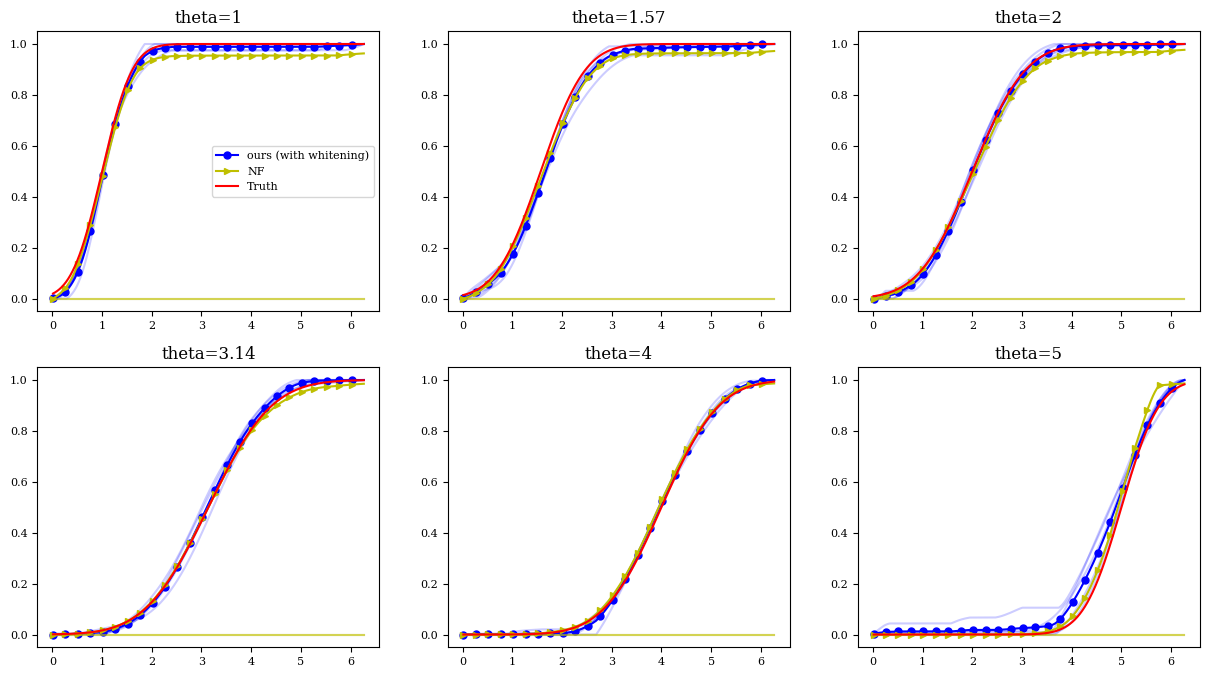

In [8]:
#x1 = np.linspace(np.min(thetas_test), np.max(thetas_test), 9) # mean
x1 = [1, 1.57, 2, 3.14, 4, 5]

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
axes = ax.flatten()

ks_dist_ncp = np.zeros((len(x1), NEXP))
ks_dist_nf = np.zeros((len(x1), NEXP))

for i, xi in enumerate(x1):
    #x_scaled = torch.Tensor(xscaler.transform([x]))
    x = np.array([np.cos(xi), np.sin(xi)])
    x_scaled = torch.Tensor([np.concatenate([x, np.zeros((d-2))]) @ H])

    our_cdfs = np.zeros((NEXP, y_discr.shape[0]))
    ddpm_cdfs = np.zeros((NEXP, y_discr.shape[0]))
    nf_cdfs = np.zeros((NEXP, y_discr.shape[0]))

    for exp in range(NEXP):
        ys, cdf_pred_center = best_models[exp].cdf(x_scaled, y_discr_torch, postprocess='whitening')
        our_cdfs[exp] = smooth_cdf(ys, cdf_pred_center)

        #fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()
        fys = ys.copy()

        #ddpm_cdfs[exp] = cdf_from_sample(best_models_ddpm[exp], x_scaled, ys)

        nf_cdfs[exp] = get_cdf_from_nf(best_models_nf[exp], x_scaled, y_discr_torch)

    true_cdf = manifold_cdf(xi, fys)


    axes[i].plot(fys, our_cdfs.mean(axis=0), '-ob', label='ours (with whitening)', markevery=40, markersize=5)
    for exp in range(NEXP):
        axes[i].plot(fys, our_cdfs[exp], '-b', alpha=0.2)

    #axes[i].plot(fys, ddpm_cdfs.mean(axis=0), '-vg', label='DDPM',markevery=40, markersize=5)
    #for exp in range(NEXP):
    #    axes[i].plot(fys, ddpm_cdfs[exp], '-g', alpha=0.2)

    axes[i].plot(fys, nf_cdfs.mean(axis=0), '->y', label='NF',markevery=40, markersize=5)
    for exp in range(NEXP):
        axes[i].plot(fys, ddpm_cdfs[exp], '-y', alpha=0.2)

    axes[i].plot(fys, true_cdf, 'r', label='Truth')
    
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'theta={round(xi, 3)}')

    for exp in range(NEXP):
        #print(np.isnan(nf_cdfs[exp]).sum())
        ks_dist_ncp[i, exp] = kolmogorov_smirnov(true_cdf, our_cdfs[exp], values=fys)
        ks_dist_nf[i, exp] = kolmogorov_smirnov(true_cdf, nf_cdfs[exp], values=fys)

del best_models
del best_models_nf

In [9]:
# printing the table for ks distances
import pandas

m_ncp = ks_dist_ncp.mean(axis=-1)
m_nf = ks_dist_nf.mean(axis=-1)
std_ncp = ks_dist_ncp.std(axis=-1)
std_nf = ks_dist_nf.std(axis=-1)

df = pandas.DataFrame(index=x1)
df['NCP mean'] = m_ncp
df['NCP std'] = std_ncp
df['NF mean'] = m_nf
df['NF std'] = std_nf

df

,NCP mean,NCP std,NF mean,NF std
1.00,0.057871,0.023059,0.027487,0.013321
1.57,0.067840,0.020620,0.029441,0.017084
2.00,0.041691,0.011749,0.022704,0.013567
3.14,0.041120,0.015993,0.016394,0.007469
4.00,0.031672,0.021759,0.040313,0.024841
5.00,0.107762,0.063568,0.099531,0.032443


In [10]:
df.to_csv()

',NCP mean,NCP std,NF mean,NF std\r\n1.0,0.05787061154842377,0.02305896687081292,0.027486547827720642,0.013321327261929371\r\n1.57,0.0678395003080368,0.020619793548463772,0.029440565407276152,0.017083501133961555\r\n2.0,0.04169054478406906,0.011748688811466774,0.0227039635181427,0.013566586737217072\r\n3.14,0.041119593754410745,0.015992617981980508,0.016393756866455077,0.007469222677835203\r\n4.0,0.03167178258299828,0.021758892712511267,0.04031328558921814,0.02484090239640208\r\n5.0,0.10776234567165374,0.06356828743240837,0.09953133463859558,0.03244308856810378\r\n'